In [92]:
import pandas as pd
import numpy as np

In [225]:
# matplotlib rebuild

import matplotlib.pyplot as plt
from matplotlib import font_manager

font_fname = 'C:/Windows/Fonts/nanummyeongjo.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()

plt.rcParams["font.family"] = font_family
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["axes.formatter.limits"] = -10000, 10000


# Load lv1

토큰화한 텍스트를 불러오는데 2020년에 사업보고서가 나온 기업(rcp_dt = 2020..)이 존재하여 제거해주었다.

In [99]:
df_price = pd.read_csv("./data/kospi/preprocessed/df_kospi200_adjusted_price.csv",index_col=0)
df_return = pd.read_csv('./data/kospi/preprocessed/df_kospi200_price_return.csv',index_col=0,low_memory=False)
df = pd.read_csv("./data/preprocessing/preprocessed/df_tokenized.csv",index_col=0)

df = df.drop('str_nouns', axis=1)
df = df.drop(405,axis=0)   
df = df.drop(1779,axis=0)
df = df.drop(2037,axis=0)
df.rcp_dt = [int(x) for x in df.rcp_dt] #dataframe index 수정

In [100]:
df.head()

,연도,crp_nm,rpt_nm,rcp_no,rcp_dt,rmk,str,str_tokens
0,2019,동화약품,사업보고서 (2018.12),2.019040e+13,20190401,연,. 이사의 경영진단 및 분석의견num. 예측정보에 대한 주의사항당사가 본 사업보고서...,. 이사 의 경영 진단 및 분석 의견 num . 예측 정보 에 대한 주 의 사항 당...
1,2018,동화약품,[기재정정]사업보고서 (2017.12),2.018062e+13,20180618,연,. 이사의 경영진단 및 분석의견num. 예측정보에 대한 주의사항당사가 본 사업보고서...,. 이사 의 경영 진단 및 분석 의견 num . 예측 정보 에 대한 주 의 사항 당...
2,2017,동화약품,[기재정정]사업보고서 (2016.12),2.017041e+13,20170405,연,. 이사의 경영진단 및 분석의견num. 예측정보에 대한 주의사항당사가 본 사업보고서...,. 이사 의 경영 진단 및 분석 의견 num . 예측 정보 에 대한 주 의 사항 당...
3,2016,동화약품,사업보고서 (2015.12),2.016033e+13,20160330,연,. 이사의 경영진단 및 분석의견num. 예측정보에 대한 주의사항당사가 본 사업보고서...,. 이사 의 경영 진단 및 분석 의견 num . 예측 정보 에 대한 주 의 사항 당...
4,2015,동화약품,사업보고서 (2014.12),2.015033e+13,20150331,연,. 이사의 경영진단 및 분석의견num. 예측정보에 대한 주의사항당사가 본 사업보고서...,. 이사 의 경영 진단 및 분석 의견 num . 예측 정보 에 대한 주 의 사항 당...


# Filter the dataset
- There are several types of report such as restatement and first published version
- For simplifying the task, I'm going to use '사업보고서' only.  

In [97]:
naive_df = df.copy()
# naive_df = df[df.rpt_nm.map(lambda x : x.split(" ")[0]) == '사업보고서']
# naive_df.sort_values("연도",inplace=True)

# Set lv2

In [98]:
def length_adjust(str_) : 
    return (2-len(str_)) * '0' + str_

def date_convertor(date) : 
    year = length_adjust(str(date.year))
    month = length_adjust(str(date.month))
    day = length_adjust(str(date.day))
    yyyymmdd = int(year+month+day)
    return yyyymmdd

In [101]:
lv2_index = df_return.index
# lv2_index = [int(x) for x in df_return.iloc[:,0][1:]]

In [102]:
# lv2_index = pd.date_range(start='20100101', end='20191231')
# lv2_index = list(map(date_convertor,lv2_index))
lv2_columns = naive_df.crp_nm.unique()

lv2_df = \
pd.DataFrame(np.full(shape=(len(lv2_index),len(lv2_columns)),fill_value=np.nan),index=lv2_index,columns=lv2_columns)

In [103]:
lv2_df.shape
# (date_list,company_list)

(2466, 275)

# Generate the lv2

In [104]:
%%time
company_list = naive_df.crp_nm.unique()
for process,corp_name in enumerate(company_list) : 
    print("Process : {} | Total : {}".format(process+1,len(company_list)),end='\r')
    # slicing the dataset by corp_name
    tmp_df = naive_df[naive_df.crp_nm == corp_name]
    
    # set-up the time range 
    min_yr = tmp_df['연도'].min()
    max_yr = tmp_df['연도'].max()
    
    # container for saving the value 
    # those lists should be refreshed every loop.
    sim_ls = []; year_ls = []
    
    for yr in range(min_yr,max_yr) : 
        pre_df = tmp_df[tmp_df['연도'] == yr]
        next_df = tmp_df[tmp_df['연도'] == yr+1]
        publish_date = tmp_df[tmp_df['연도'] == yr+1]['rcp_dt']
        if len(pre_df) == 0 or len(next_df) == 0:
            continue
            # we don't have data
            # for example, we have 2014 but don't 2015.
            # therfore we can't measure similarity between 2014,2015.
            # so the value in lv2 at 2015 should be nan
            
        else : 
            pre_token = pre_df.str_tokens.map(lambda x : x.split(" ")).values
            next_token = next_df.str_tokens.map(lambda x : x.split(" ")).values   
            if type(pre_token[0]) == list and type(next_token[0]) == list :
                sim = len(set(next_token[0])&set(pre_token[0]))/len(set(next_token[0]))
            else : 
                 sim = len(set(next_token)&set(pre_token))/len(set(next_token))
        year_ls.append(publish_date.values[0])
        sim_ls.append(sim)
        
    assert len(year_ls) == len(sim_ls)
    lv2_df.loc[year_ls,corp_name] = sim_ls    

Wall time: 5.59 sotal : 275


# Check the lv2
- if we apply mean operation through time, we can take overall auto-regressive similarity per company.

lv2 데이터의 index는 2010-2019년의 daily trading day, columns는 크롤링된 해당 기간에 편입되었던 기업들이다.

사업보고서 발행날짜인 rcp_dt를 저장하여 사업보고서가 발행된 날짜(기재정정이 있을 경우는 정정날짜)와 해당 기업의 auto-regressive similarity를 저장하였다. 이를 평균내서 10년동안의 사업보고서의 유사도의 변화를 수치화 할 수 있었으며 이를 통해 유의미한 결과를 도출해 보고자 하였다.

In [297]:
lv2_df.head()

,동화약품,우리은행,경방,삼양홀딩스,하이트진로,유한양행,CJ대한통운,하이트진로홀딩스,두산,일동홀딩스,...,한섬,일진머티리얼즈,일진디스플,코웨이,롯데쇼핑,대우조선해양,한전기술,신한지주,후성,한진중공업
20100104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20100105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20100106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20100107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20100108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


해당 기간 내의 기업들의 유사도를 평균내어 데이터프레임으로 저장하였고 이를 기반으로 유사도가 낮은 기업과 높은 기업들을 clustering하여 사업보고서 발간 날짜 이후 일정 기간동안의 누적수익률을 비교해보려고 한다. 

유사도들의 평균값은 0.74이고 제일 낮은 기업은 0.47, 높은 기업은 '코스맥스'로 1의 값이였는데 사업보고서 확인 결과 개요를 제외한 부분이 재무제표 table이라 제외된 결과 이러한 값이 나온것 같다. 일단은 내용상의 변화가 적은 것으로 해석하겠다.

In [309]:
df_sim_mean = pd.DataFrame(lv2_df.mean().sort_values(ascending=True),columns={'평균유사도'})
df_sim_mean = df_sim_mean.dropna()
df_sim_mean.describe()

,평균유사도
count,271.000000
mean,0.742485
std,0.086552
min,0.475263
25%,0.690511
50%,0.746172
75%,0.795979
max,1.000000


In [310]:
df_sim_mean.head(10)

,평균유사도
고려제강,0.475263
케이피케미칼,0.514134
한독,0.518269
대우조선해양,0.542492
알바이오,0.543312
코오롱,0.546697
일동홀딩스,0.559503
포스코플랜텍,0.566621
현대그린푸드,0.567742
SK케미칼,0.573209


In [305]:
df_sim_mean.tail(10)

,평균유사도
만도,0.903340
휠라홀딩스,0.908435
한샘,0.915647
디티알오토모티브,0.918303
GKL,0.925793
오리온,0.928070
세종공업,0.937490
디와이,0.955789
애경산업,0.994475
코스맥스,1.000000


In [329]:
def cumprod_return(name,period):
    
    dic_index = {idx:i for i,idx in enumerate(df_price.index)}
    dic_column = {idx:i for i,idx in enumerate(df_price.columns)}
    
    
    rcp_ls = [x for x in df[df.crp_nm == name].rcp_dt]
    rcp_ls.sort(reverse=False)
    
    k = [(df_price.iloc[dic_index.get(i):dic_index.get(i)+period , dic_column.get(name)]/
         df_price.iloc[dic_index.get(i),dic_column.get(name)]-1)*100 for i in rcp_ls]
    df_comprod = (pd.concat([j[period-1:] for j in k],ignore_index=False)).to_frame()
    
    return df_comprod

In [398]:
def compare(corp1,corp2,corp3,corp4,period):
    
    a1 = cumprod_return(corp1,period)
    a2 = cumprod_return(corp2,period)
    a3 = cumprod_return(corp3,period)
    a4 = cumprod_return(corp4,period)
    

    fig = plt.figure()
    
    ax1 = fig.add_subplot(2,2,1)
    ax1.plot(a1, label=corp1)
    plt.legend(loc='upper left')
    
    ax2 = fig.add_subplot(2,2,2)
    ax2.plot(a2, label=corp2)
    plt.legend(loc='upper left')
    
    ax3 = fig.add_subplot(2,2,3)
    ax3.plot(a3, label=corp3)
    plt.legend(loc='upper left')
    
    ax4 = fig.add_subplot(2,2,4)
    ax4.plot(a4, label=corp4)
    plt.legend(loc='upper left')
    
    return plt.show()

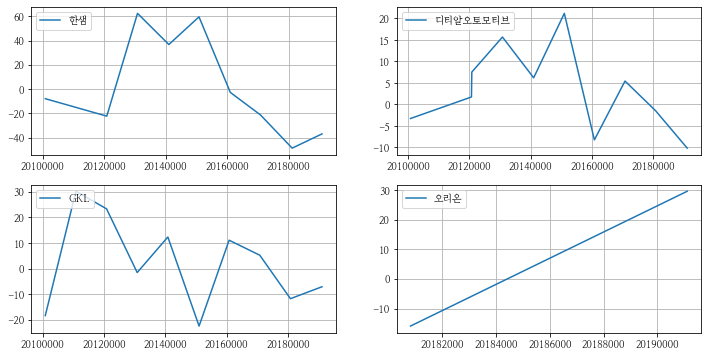

In [402]:
compare('한샘','디티알오토모티브','GKL','오리온',100)

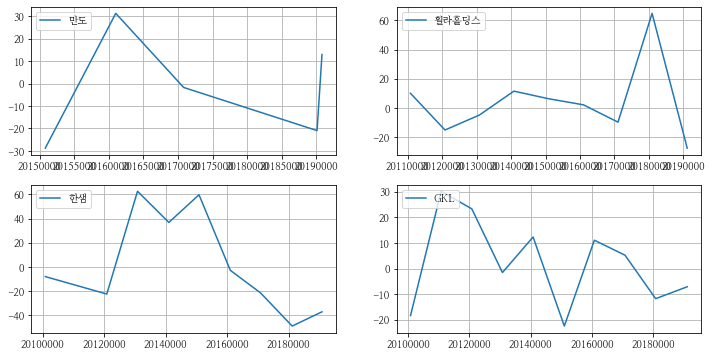

In [403]:
compare('만도','휠라홀딩스','한샘','GKL',100)